In [1]:
import os
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import neighbors, tree, feature_selection
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import confusion_matrix, mean_squared_error, roc_auc_score, roc_curve

In [2]:
os.chdir("/Users/adeniyiharrison/Desktop/umn_foursquare_datasets")
users = pd.read_table(open("users.dat"), sep = "|", skiprows = 0, skipfooter = 1)
venues = pd.read_table(open("venues.dat"), sep = "|")
ratings = pd.read_table(open("ratings.dat"), sep = "|")
social = pd.read_table(open("socialgraph.dat"), sep = "|")
checkin = pd.read_table(open("checkins.dat"), sep = "|")

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  from ipykernel import kernelapp as app
//anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0,1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
//anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### Users Data Clean

In [3]:
users.columns = ["id", "lat", "long"]
users.drop([0,2153470], inplace = True)
users["id"] = users["id"].apply(lambda x: int(x))

userLat = []
for x in users["lat"]:
    try:
        userLat.append(float(x))
    except:
        userLat.append(np.nan)
        

userLong = []
for x in users["long"]:
    try:
        userLong.append(float(x))
    except:
        userLong.append(np.nan)
        

users["lat"] = userLat
users["long"] = userLong

users.sort_values("id", ascending = True, inplace = True)
users.set_index("id", inplace = True)

#### Venue Data Clean

In [4]:
venues.columns = ["id", "lat", "long"]
venues.drop([0, 1143091], inplace = True)
venues["id"] = venues["id"].apply(lambda x: int(x))

venueLat = []
for x in venues["lat"]:
    try:
        venueLat.append(float(x))
    except:
        venueLat.append(np.nan)

venueLong = []
for x in venues["long"]:
    try:
        venueLong.append(float(x))
    except:
        venueLong.append(np.nan)

venues["lat"] = venueLat
venues["long"] = venueLong

venues.sort_values("id", ascending = True, inplace = True)
venues.set_index("id", inplace = True)

#### Rating Data Clean

In [5]:
ratings.drop([0,2809581], inplace = True)
ratings.columns = ["user_id", "venue_id", "rating"]
ratings["user_id"] = ratings["user_id"].apply(lambda x: int(x))
ratings["venue_id"] = ratings["venue_id"].apply(lambda x: int(x))
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))

#### Social Data Clean

In [6]:
social.drop([0,27098473, 27098474, 27098475, 27098476, 27098477, 27098478,
       27098479, 27098480, 27098481, 27098482, 27098483, 27098484,
       27098485, 27098486, 27098487, 27098487, 27098488], inplace = True)

social.columns = ["first_user_id", "second_user_id"]

first = []
second = []
for x in social["first_user_id"]:
    try:
        x = x.replace(" ", "")
        first.append(int(x))
    except:
        first.append(x)
        
for x in social["second_user_id"]:
    try:
        x = x.replace(" ", "")
        second.append(int(x))
    except:
        second.append(x)

social["first_user_id"] = first
social["second_user_id"] = second

#### Check In Data Clean

In [7]:
checkin.drop([0,1021967], inplace = True)
checkin.columns = ["id", "user_id", "venue_id", "lat", "long", "timestamp"]

checkID = []
userID = []
venueID = []
lat = []
long = []
time = []
for x in checkin["id"]:
    try:
        checkID.append(int(x))
    except:
        checkID.append(np.nan)

for x in checkin["user_id"]:
    try:
        userID.append(int(x))
    except:
        userID.append(np.nan)

for x in checkin["venue_id"]:
    try:
        venueID.append(int(x))
    except:
        venueID.append(np.nan)

for x in checkin["lat"]:
    try:
        lat.append(float(x))
    except:
        lat.append(np.nan)

for x in checkin["long"]:
    try:
        long.append(float(x))
    except:
        long.append(np.nan)

for x in checkin["timestamp"]:
    if pd.isnull(x):
        time.append(np.nan)
    else:
        time.append(x)

checkin["id"] = checkID
checkin["user_id"] = userID
checkin["venue_id"] = venueID
checkin["lat"] = lat
checkin["long"] = long
checkin["timestamp"] = time

checkin.sort_values("id", ascending = True, inplace = True)
checkin.set_index("id", inplace = True)
checkin["timestamp"] = checkin["timestamp"].apply(lambda x: datetime.datetime.strptime(x, " %Y-%m-%d %H:%M:%S"))
checkin["Year"] = checkin["timestamp"].apply(lambda x: x.year)
checkin["Month"] = checkin["timestamp"].apply(lambda x: x.month)
checkin["Day"] = checkin["timestamp"].apply(lambda x: x.day)
checkin["Hour"] = checkin["timestamp"].apply(lambda x: x.hour)

#### Save DataFrames

In [130]:
os.chdir("/Users/adeniyiharrison/Desktop/umn_foursquare_datasets/Cleaned")
# users.to_csv("Users.csv")
# venues.to_csv("Venues.csv")
# ratings.to_csv("Ratings.csv")
# checkin.to_csv("CheckIns.csv")
# social.to_csv("SocialGraph.csv")

### Analysis

In [8]:
users.reset_index(inplace = True)
users.columns = ["user_id", "user_lat", "user_long"]

venues.reset_index(inplace = True)
venues.columns = ["venue_id", "venue_lat", "venue_long"]

In [9]:
userData = users.merge(ratings, left_on = "user_id", right_on = "user_id")
userData = userData.merge(venues, left_on = "venue_id", right_on = "venue_id")

In [10]:
avgUserRating = pd.DataFrame(userData.groupby("user_id")["rating"].mean())

In [11]:
firstFriend = pd.DataFrame(social.groupby("first_user_id")["first_user_id"].count())

In [12]:
avgUserRating = avgUserRating.join(firstFriend)
avgUserRating.columns = ["Avg Rating", "Total Friends"]
avgUserRating["Total Friends"].fillna(0, inplace = True)

In [13]:
userData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2809580 entries, 0 to 2809579
Data columns (total 7 columns):
user_id       int64
user_lat      float64
user_long     float64
venue_id      int64
rating        float64
venue_lat     float64
venue_long    float64
dtypes: float64(5), int64(2)
memory usage: 171.5 MB


In [14]:
avgUserRating.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 661986 entries, 1 to 2153502
Data columns (total 2 columns):
Avg Rating       661986 non-null float64
Total Friends    661986 non-null float64
dtypes: float64(2)
memory usage: 15.2 MB


#### Linear Regression

In [22]:
X = avgUserRating["Total Friends"]
y = avgUserRating["Avg Rating"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

lr = LinearRegression()

In [23]:
algo = lr.fit(X_train.reshape(len(X_train),1),y_train)

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if __name__ == '__main__':


In [ ]:
feature_selection.

In [29]:
pvals = feature_selection.f_regression(X_train.reshape(len(X_train),1),y_train)[1]

print("P Values: ", pvals)
print("Coeff: ", algo.coef_)
print("Y Intercept: ", algo.intercept_)
print("R Squared: ", algo.score(X_train.reshape(len(X_train), 1), y_train))




P Values:  [ 0.]
Coeff:  [ 0.00018182]
Y Intercept:  2.7026597934
R Squared:  0.0049533429468


//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if __name__ == '__main__':
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if __name__ == '__main__':
//anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
//anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:611: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


(array([  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        

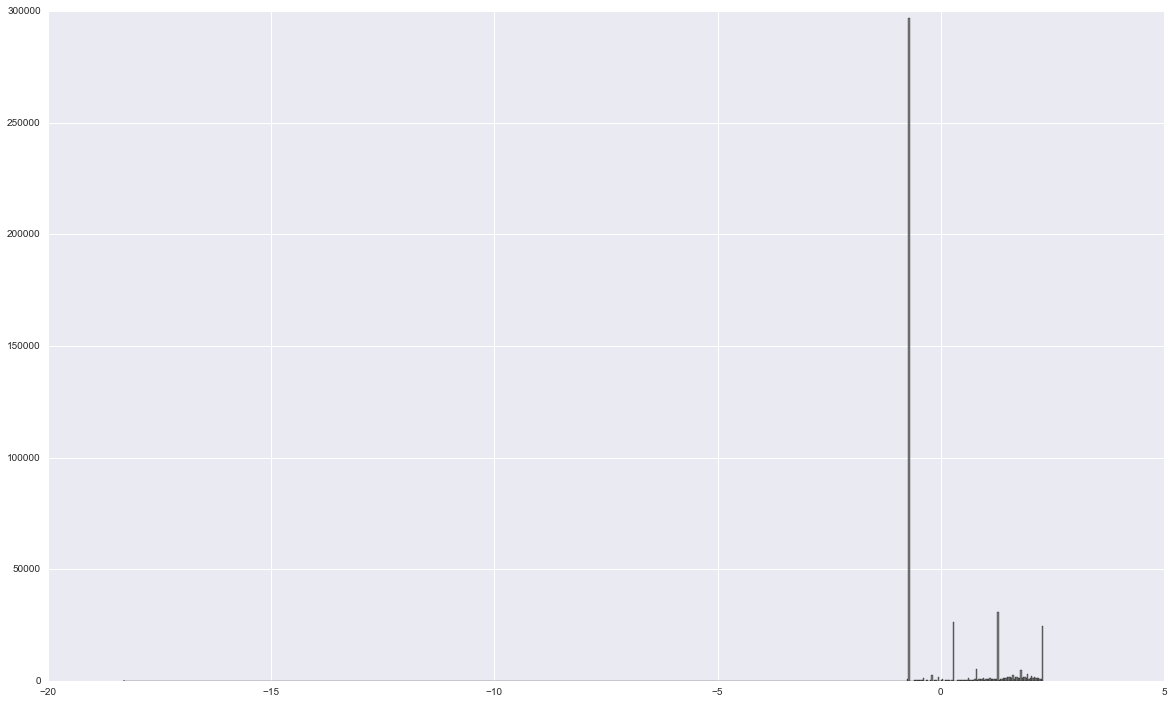

In [32]:
residuals = (y_train - algo.predict(X_train.reshape(len(X_train),1))).values
bins = np.round(np.sqrt(len(residuals)))

plt.figure(figsize = (20,12))
plt.hist(residuals, bins = bins, color = "grey")